In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AAON.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,9.506667,9.600000,9.337778,9.453333,8.950765,501000
1,1/3/2013,9.444445,9.746667,9.382222,9.617778,9.106468,344700
2,1/4/2013,9.662222,9.697778,9.546667,9.666667,9.152760,141300
3,1/7/2013,9.604445,9.688889,9.537778,9.560000,9.051764,132000
4,1/8/2013,9.577778,9.640000,9.422222,9.582222,9.072803,103200


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 174.930023.3, cost: 0.003167, total money: 10174.930023
epoch: 20, total rewards: 159.379969.3, cost: 0.011891, total money: 9515.939962
epoch: 30, total rewards: 392.545586.3, cost: 0.000956, total money: 10292.935585
epoch: 40, total rewards: 233.473285.3, cost: 0.003795, total money: 10233.473285
epoch: 50, total rewards: 24.436672.3, cost: 0.002684, total money: 9875.476673
epoch: 60, total rewards: 59.015545.3, cost: 0.000237, total money: 10059.015545
epoch: 70, total rewards: 79.006695.3, cost: 0.000633, total money: 10079.006695
epoch: 80, total rewards: 67.677774.3, cost: 0.000731, total money: 10018.297773
epoch: 90, total rewards: 64.557767.3, cost: 0.000468, total money: 10014.747765
epoch: 100, total rewards: -3.375578.3, cost: 0.001574, total money: 9897.344419
epoch: 110,

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 9.871111, total balance 9990.128889
day 8, sell 1 unit at price 10.053333, investment 1.846017 %, total balance 10000.182222,
day 25: buy 1 unit at price 10.493333, total balance 9989.688890
day 28, sell 1 unit at price 10.617778, investment 1.185943 %, total balance 10000.306667,
day 32: buy 1 unit at price 10.764444, total balance 9989.542223
day 34, sell 1 unit at price 10.622222, investment -1.321224 %, total balance 10000.164445,
day 42: buy 1 unit at price 10.951111, total balance 9989.213334
day 43, sell 1 unit at price 10.951111, investment 0.000000 %, total balance 10000.164445,
day 44: buy 1 unit at price 11.071111, total balance 9989.093334
day 45, sell 1 unit at price 11.128889, investment 0.521884 %, total balance 10000.222223,
day 47: buy 1 unit at price 11.031111, total balance 9989.191113
day 48, sell 1 unit at price 11.333333, investment 2.739726 %, total balance 10000.524446,
day 50: buy 1 unit at price 11.617778, total balance 9988.906668
d

day 676: buy 1 unit at price 20.000000, total balance 9979.907784
day 677, sell 1 unit at price 19.879999, investment -0.600004 %, total balance 9999.787783,
day 684: buy 1 unit at price 20.090000, total balance 9979.697783
day 685, sell 1 unit at price 19.750000, investment -1.692385 %, total balance 9999.447783,
day 691: buy 1 unit at price 19.379999, total balance 9980.067783
day 692, sell 1 unit at price 19.190001, investment -0.980385 %, total balance 9999.257784,
day 694: buy 1 unit at price 20.290001, total balance 9978.967783
day 695, sell 1 unit at price 20.030001, investment -1.281420 %, total balance 9998.997784,
day 704: buy 1 unit at price 21.240000, total balance 9977.757784
day 705, sell 1 unit at price 21.120001, investment -0.564967 %, total balance 9998.877785,
day 715: buy 1 unit at price 22.719999, total balance 9976.157785
day 716, sell 1 unit at price 24.480000, investment 7.746480 %, total balance 10000.637785,
day 752: buy 1 unit at price 23.520000, total balanc

day 1035, sell 1 unit at price 34.349998, investment 2.232143 %, total balance 9934.117790,
day 1036, sell 1 unit at price 35.000000, investment 3.092781 %, total balance 9969.117790,
day 1037, sell 1 unit at price 34.450001, investment 0.291127 %, total balance 10003.567791,
day 1039: buy 1 unit at price 34.950001, total balance 9968.617790
day 1041, sell 1 unit at price 34.650002, investment -0.858367 %, total balance 10003.267792,
day 1042: buy 1 unit at price 34.400002, total balance 9968.867790
day 1043, sell 1 unit at price 31.950001, investment -7.122095 %, total balance 10000.817791,
day 1056: buy 1 unit at price 35.349998, total balance 9965.467793
day 1057, sell 1 unit at price 36.200001, investment 2.404533 %, total balance 10001.667793,
day 1064: buy 1 unit at price 36.250000, total balance 9965.417793
day 1065, sell 1 unit at price 35.049999, investment -3.310347 %, total balance 10000.467793,
day 1068: buy 1 unit at price 35.250000, total balance 9965.217793
day 1069, sel

day 1440: buy 1 unit at price 40.250000, total balance 9963.667791
day 1441, sell 1 unit at price 39.849998, investment -0.993793 %, total balance 10003.517790,
day 1461: buy 1 unit at price 32.209999, total balance 9971.307791
day 1462: buy 1 unit at price 32.380001, total balance 9938.927790
day 1463, sell 1 unit at price 32.369999, investment 0.496740 %, total balance 9971.297789,
day 1465, sell 1 unit at price 33.500000, investment 3.458922 %, total balance 10004.797789,
day 1468: buy 1 unit at price 34.349998, total balance 9970.447790
day 1470, sell 1 unit at price 38.220001, investment 11.266384 %, total balance 10008.667791,
day 1475: buy 1 unit at price 43.830002, total balance 9964.837790
day 1476, sell 1 unit at price 43.259998, investment -1.300487 %, total balance 10008.097788,
day 1478: buy 1 unit at price 43.119999, total balance 9964.977789
day 1479, sell 1 unit at price 41.520000, investment -3.710572 %, total balance 10006.497789,
day 1499: buy 1 unit at price 35.2999

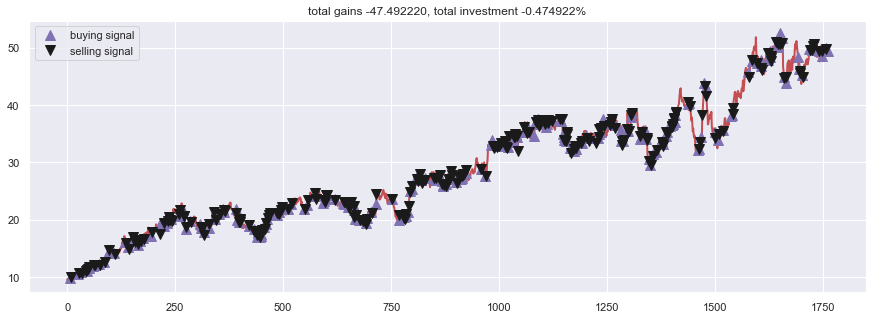

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()